# 1083 Albumin Initial ML

### By: Ian Weimer

In [1]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.7.0


In [2]:
#print("Imbalanced-Learn", imbalanced-learn.__version__)

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [4]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/GI_Bleed_Tables/blood_diseases_matched_alb_24h_full.csv')

In [5]:
df.CCI.value_counts()

3     1625
4     1531
5     1380
6     1233
7      996
8      759
2      749
1      617
9      509
10     335
0      265
11     184
12     104
13      50
14      29
15      12
16       5
17       3
18       2
Name: CCI, dtype: int64

In [6]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [7]:
df.head()

encounterid  ICU  mass_transfusion  \
0  83aedaea-94b0-405c-a1ea-94fee7f50b52    1                 0   
1  b08d47a1-2a9e-4b7a-b008-f71641dcb93a    0                 0   
2  a3756a81-c2d1-41bd-831d-cc65e73299c6    1                 1   
3  d58ab90d-6928-4e32-af06-c3479e437faa    0                 0   
4  008fb547-53e0-467e-92b2-590982e390b8    1                 0   

   total_transfusions  anemia_status  CCI  bl_albumin_value  qSOFA  Cirrhosis  \
0                   0            0.0    4               3.5      1          0   
1                   0            0.0    2               3.9      0          0   
2                   0            0.0    1               3.5      1          0   
3                   0            2.0    4               2.2      0          1   
4                   1            2.0    6               3.3      1          0   

   beta_blocker  hemorrhagic  SAPS  propensity_score  propensity_logit  \
0             1            0    34          0.492114         -0.031547   
1             1            0    41          0.296393         -0.864535   
2             0            0    29          0.615716          0.471403   
3             1            1    31          0.784942          1.294700   
4             1            1    20          0.509232          0.036933   

   albumin_24hrs                              personid   LOS_hours  \
0              1  1df390c3-18b8-41b0-acd9-23495059e97a  343.133333   
1              1  1f7e4dd3-9985-4039-8099-ecea6ec7b94d  333.866667   
2              1  3cc07cf0-d9b1-486a-a33f-7a0db69304dd   23.400000   
3              1  3e61e48c-91d7-466b-8dff-89c791002dc6  239.300000   
4              1  43c7671f-8311-40d6-861f-91e668874c01  173.100000   

   30_day_mortality  30_day_readmission  
0                 0                   1  
1                 0                   0  
2                 1                   0  
3                 0                   1  
4                 0                   0

In [8]:
df.shape

(10388, 19)

In [9]:
df.propensity_logit.describe()

count    10388.000000
mean         0.675583
std          1.098092
min         -2.645875
25%         -0.084107
50%          0.710499
75%          1.451933
max          3.630297
Name: propensity_logit, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [10]:
df[df['albumin_24hrs'] == 1]['30_day_mortality'].value_counts()

0    4103
1    1091
Name: 30_day_mortality, dtype: int64

In [11]:
print((1091/(1091+4103)) * 100)

21.005005775895263


In [12]:
df[df['albumin_24hrs'] == 0]['30_day_mortality'].value_counts()

0    4452
1     742
Name: 30_day_mortality, dtype: int64

In [13]:
print((742/(742 + 4452)) * 100)

14.285714285714285


In [154]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit'], inplace=True)

In [155]:
df.drop(columns=['30_day_readmission', 'LOS_hours'], inplace=True)

In [156]:
# remove non-baseline variables

df.drop(columns=['beta_blocker', 'bl_albumin_value', 'SAPS', 'qSOFA'], inplace=True)

In [18]:
df.describe()

ICU  mass_transfusion  total_transfusions  anemia_status  \
count  10388.000000      10388.000000        10388.000000   10388.000000   
mean       0.313150          0.064497            0.576146       1.731806   
std        0.463797          0.245649            0.949519       1.098535   
min        0.000000          0.000000            0.000000       0.000000   
25%        0.000000          0.000000            0.000000       1.000000   
50%        0.000000          0.000000            0.000000       2.000000   
75%        1.000000          0.000000            1.000000       3.000000   
max        1.000000          1.000000            5.000000       3.000000   

                CCI  bl_albumin_value         qSOFA     Cirrhosis  \
count  10388.000000      10388.000000  10388.000000  10388.000000   
mean       5.108009          2.629347      0.883038      0.538987   
std        2.767573          0.695624      0.829843      0.498502   
min        0.000000          0.002700      0.000000      0.000000   
25%        3.000000          2.100000      0.000000      0.000000   
50%        5.000000          2.600000      1.000000      1.000000   
75%        7.000000          3.100000      1.000000      1.000000   
max       18.000000          5.300000      3.000000      1.000000   

       beta_blocker   hemorrhagic          SAPS  propensity_score  \
count  10388.000000  10388.000000  10388.000000      10388.000000   
mean       0.362052      0.172122     33.264440          0.632798   
std        0.480617      0.377504     12.851008          0.214764   
min        0.000000      0.000000      0.000000          0.066244   
25%        0.000000      0.000000     24.000000          0.478986   
50%        0.000000      0.000000     32.000000          0.670511   
75%        1.000000      0.000000     42.000000          0.810296   
max        1.000000      1.000000     64.000000          0.974176   

       propensity_logit  albumin_24hrs     LOS_hours  30_day_mortality  \
count      10388.000000   10388.000000  10388.000000      10388.000000   
mean           0.675583       0.500000    251.110433          0.176454   
std            1.098092       0.500024    220.779942          0.381224   
min           -2.645875       0.000000      6.916667          0.000000   
25%           -0.084107       0.000000    101.175000          0.000000   
50%            0.710499       0.500000    174.862361          0.000000   
75%            1.451933       1.000000    320.020417          0.000000   
max            3.630297       1.000000   1292.800000          1.000000   

       30_day_readmission  
count        10388.000000  
mean             0.323643  
std              0.467888  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              1.000000  
max              1.000000

In [158]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Pull Out and Analyze Subgroups from Full Dataset

In [14]:
s_group1 = df[df['Cirrhosis'] < 1]

In [15]:
s_group1['30_day_mortality'].value_counts()

0    4053
1     736
Name: 30_day_mortality, dtype: int64

In [16]:
s_group1 = df.loc[(df['albumin_24hrs'] > 0.5) & (df['Cirrhosis'] < 0.5) & (df['anemia_status'] > 2.5)]

In [17]:
s_group1['30_day_mortality'].value_counts()

0    508
1     65
Name: 30_day_mortality, dtype: int64

In [19]:
s_group1['LOS_hours'].describe()

count     573.000000
mean      212.833371
std       176.898606
min        15.033333
25%        95.750000
50%       161.733333
75%       268.800000
max      1106.616667
Name: LOS_hours, dtype: float64

In [54]:
print('30 Day Mortality Rate (pct):',  (65/(65 + 508)) * 100)

30 Day Mortality Rate (pct): 11.343804537521814


In [20]:
s_group1_control = df.loc[(df['albumin_24hrs'] < 0.5) & (df['Cirrhosis'] < 0.5) & (df['anemia_status'] > 2.5)]

In [21]:
s_group1_control['30_day_mortality'].value_counts()

0    543
1     98
Name: 30_day_mortality, dtype: int64

In [22]:
s_group1_control['LOS_hours'].describe()

count     641.000000
mean      204.850666
std       174.167582
min         8.166667
25%        93.600000
50%       148.983333
75%       263.283333
max      1216.516667
Name: LOS_hours, dtype: float64

In [55]:
print('30 Day Mortality Rate (pct):', (251/(251 + 1559)) * 100)

30 Day Mortality Rate (pct): 13.867403314917127


In [34]:
# percentage difference

print(13.87 - 11.34)

2.5299999999999994


In [36]:
s_group1_df = pd.concat([s_group1, s_group1_control])

In [37]:
s_group1_df.shape

(2383, 19)

In [38]:
contigency= pd.crosstab(s_group1_df['albumin_24hrs'], s_group1_df['30_day_mortality'])
contigency

30_day_mortality     0    1
albumin_24hrs              
0                 1559  251
1                  508   65

In [40]:
from scipy.stats import chi2_contingency

#Chi-square test of independence.
c, p, dof, expected = chi2_contingency(contigency)
 
print("p_value: ",round(p,3))

p_value:  0.138


In [42]:
s_group2 = df.loc[(df['albumin_24hrs'] > 0.5) & (df['anemia_status'] > 2.5)]

In [43]:
s_group2['30_day_mortality'].value_counts()

0    1153
1     255
Name: 30_day_mortality, dtype: int64

In [49]:
print('30 Day Mortality Rate (pct):',  (255/(255 + 1153)) * 100)

30 Day Mortality Rate: 18.110795454545457


In [45]:
s_group2_control = df.loc[(df['anemia_status'] > 2.5)]

In [46]:
s_group2_control['30_day_mortality'].value_counts()

0    2410
1     465
Name: 30_day_mortality, dtype: int64

In [50]:
print('30 Day Mortality Rate (pct):',  (465/(465 + 2410)) * 100)

30 Day Mortality Rate: 16.17391304347826


## Modeling

In [159]:
# establish target feature, LOS_days, as y feature
y = df['30_day_mortality']
# drop target feature from features dataframe
X = df.drop(columns = ['30_day_mortality'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [160]:
cols

Index(['ICU', 'mass_transfusion', 'total_transfusions', 'anemia_status', 'CCI',
       'Cirrhosis', 'hemorrhagic', 'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [161]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [162]:
X.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  Cirrhosis  \
0    1                 0                   0            0.0    4          0   
1    0                 0                   0            0.0    2          0   
2    1                 1                   0            0.0    1          0   
3    0                 0                   0            2.0    4          1   
4    1                 0                   1            2.0    6          0   

   hemorrhagic  albumin_24hrs  
0            0              1  
1            0              1  
2            0              1  
3            1              1  
4            1              1

In [163]:
X.shape

(10388, 8)

## Train Test Split

In [164]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 2, 3, \
                                                     5, 6, 7])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [165]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [166]:
# what tree uses in flowchart

y_train.value_counts()

0    6834
1    6834
Name: 30_day_mortality, dtype: int64

In [167]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [168]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.19485
Feature: mass_transfusion Score: -0.02384
Feature: total_transfusions Score: -0.04811
Feature: anemia_status Score: -0.02237
Feature: CCI Score: 0.02467
Feature: Cirrhosis Score: 0.08749
Feature: hemorrhagic Score: 0.17279
Feature: albumin_24hrs Score: 0.22458


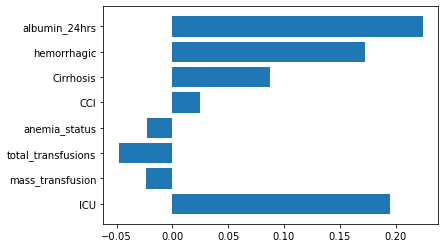

In [169]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                    Importance
albumin_24hrs         1.251800
ICU                   1.215134
hemorrhagic           1.188618
Cirrhosis             1.091434
CCI                   1.024977
anemia_status         0.977878
mass_transfusion      0.976439
total_transfusions    0.953032


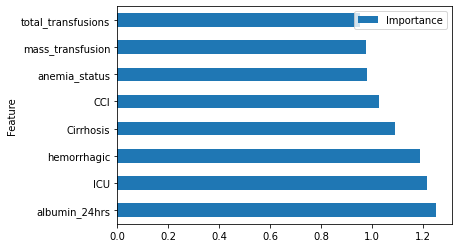

In [170]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [171]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [172]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3878 2956]
 [3020 3814]]


In [173]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.56      0.57      0.56      6834
           1       0.56      0.56      0.56      6834

    accuracy                           0.56     13668
   macro avg       0.56      0.56      0.56     13668
weighted avg       0.56      0.56      0.56     13668



In [174]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[954 767]
 [134 223]]


In [175]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      1721
           1       0.23      0.62      0.33       357

    accuracy                           0.57      2078
   macro avg       0.55      0.59      0.51      2078
weighted avg       0.76      0.57      0.62      2078



## 1: Decision Tree (Max Depth=3)

In [176]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.04550
Feature: mass_transfusion Score: 0.00000
Feature: total_transfusions Score: 0.03983
Feature: anemia_status Score: 0.14851
Feature: CCI Score: 0.26238
Feature: Cirrhosis Score: 0.18566
Feature: hemorrhagic Score: 0.00000
Feature: albumin_24hrs Score: 0.31813


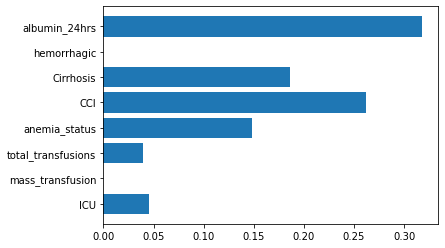

In [177]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [178]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [179]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2797 4037]
 [1738 5096]]


In [180]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.41      0.49      6834
           1       0.56      0.75      0.64      6834

    accuracy                           0.58     13668
   macro avg       0.59      0.58      0.57     13668
weighted avg       0.59      0.58      0.57     13668



In [181]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[ 688 1033]
 [  96  261]]


In [182]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      1721
           1       0.20      0.73      0.32       357

    accuracy                           0.46      2078
   macro avg       0.54      0.57      0.43      2078
weighted avg       0.76      0.46      0.51      2078



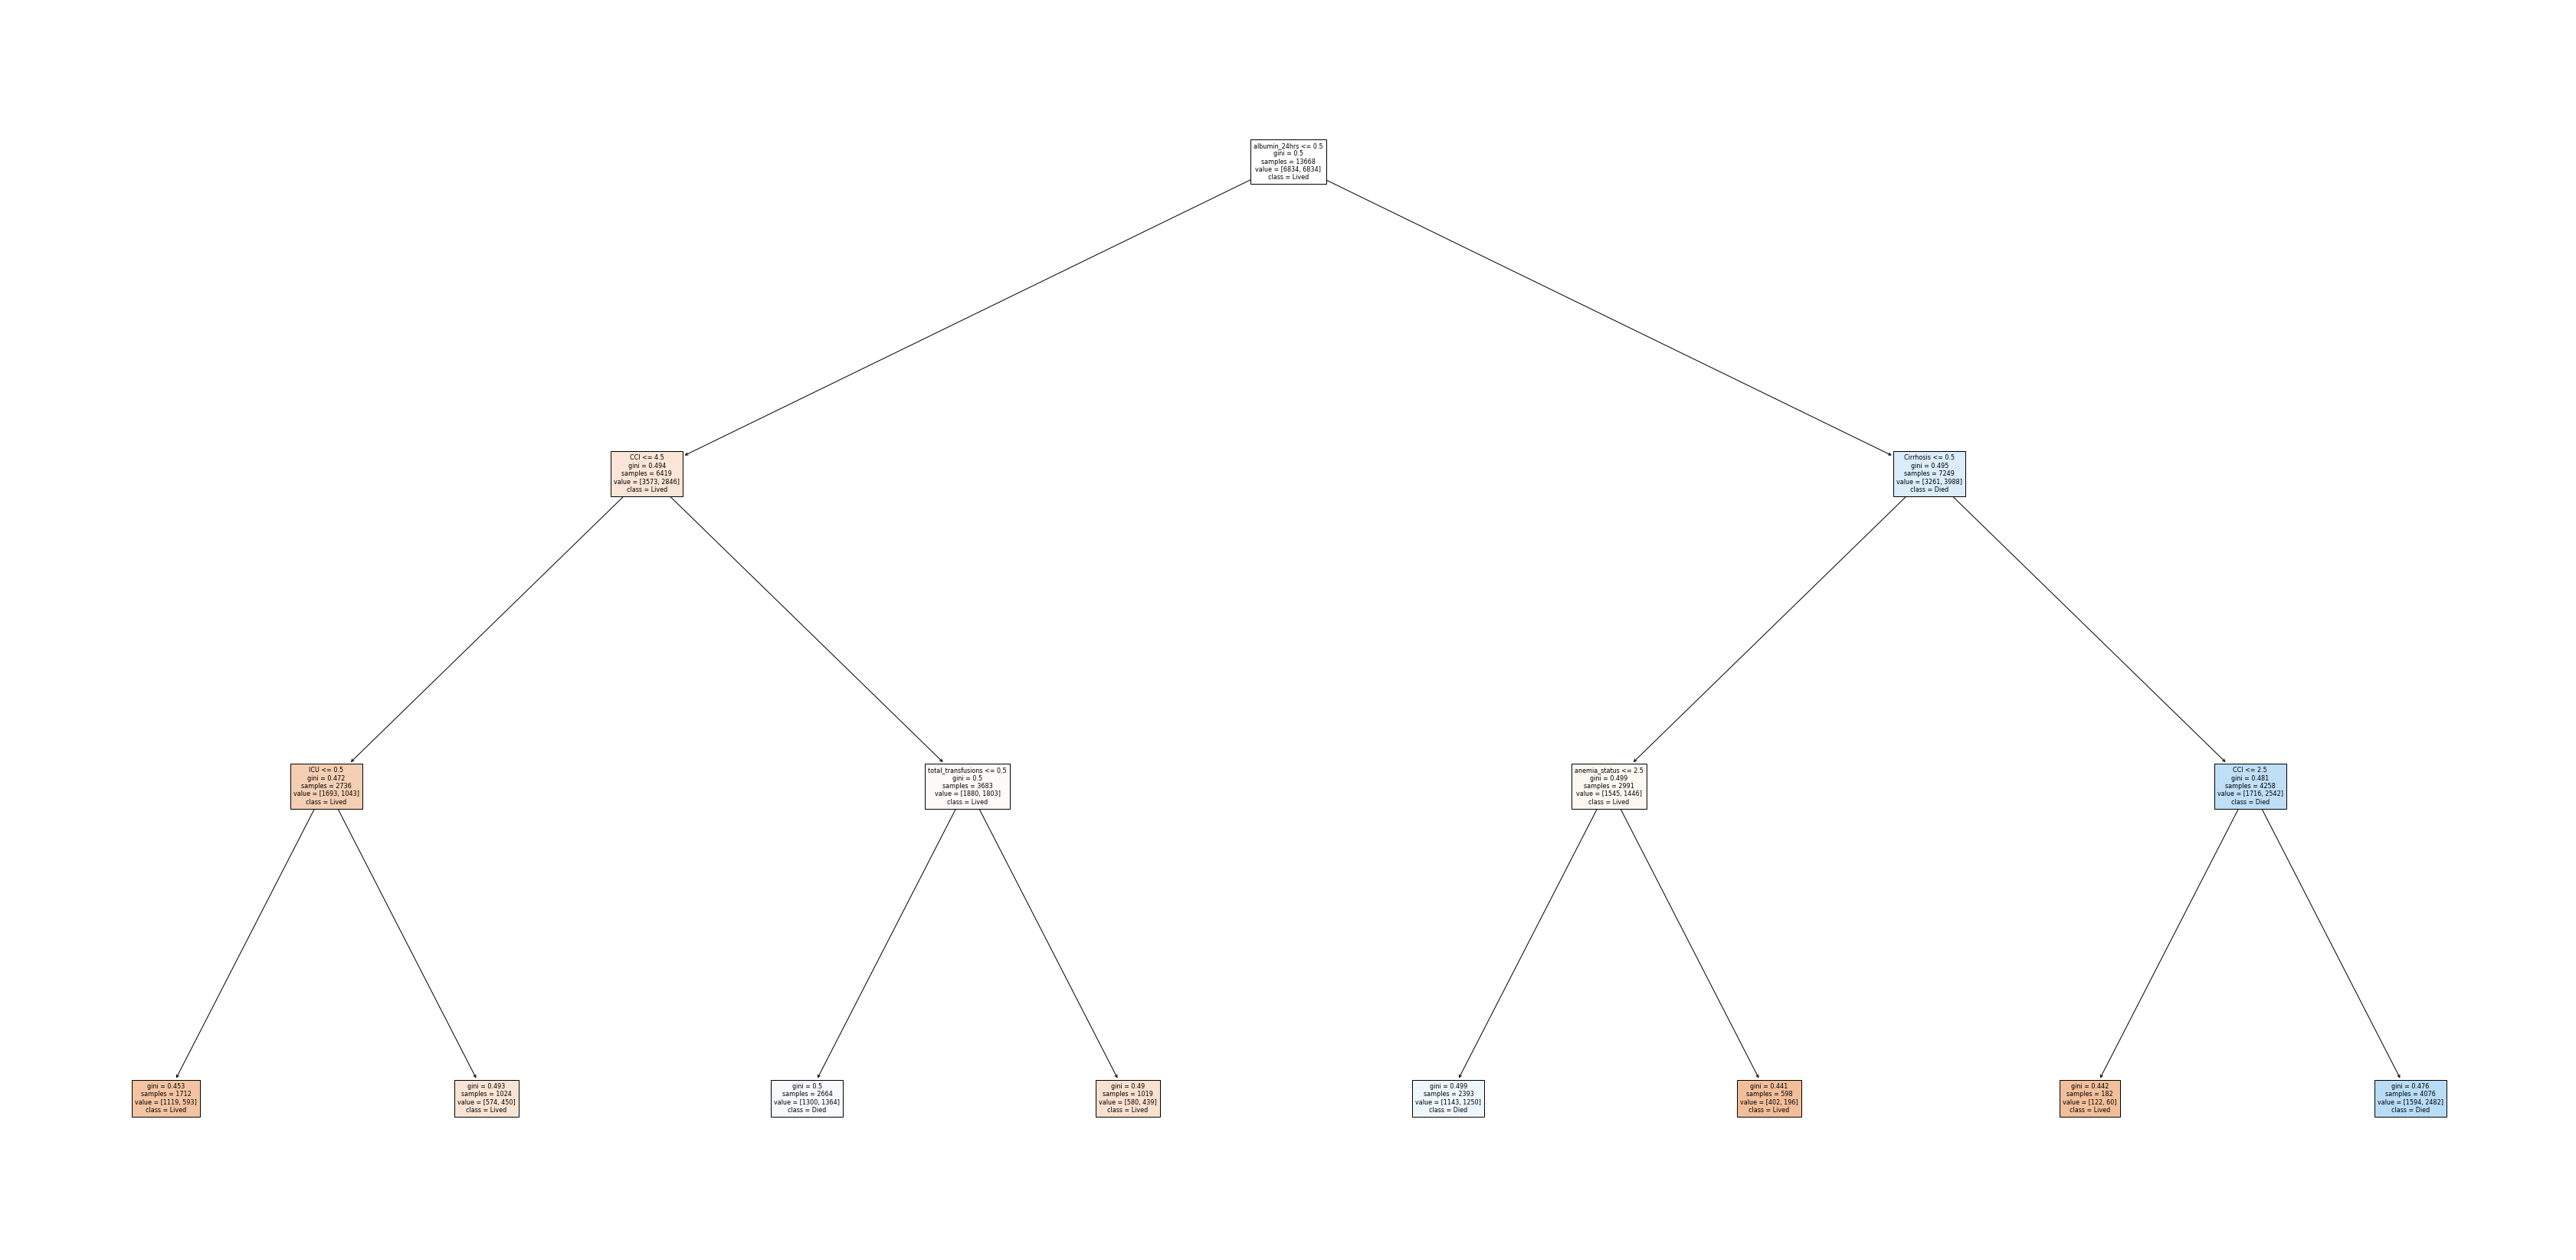

In [183]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [186]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D3_NCBL_MATCHED.png')

True

## 2: Decision Tree (Max Depth=4)

In [18]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [19]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

NameError: name 'X_train' is not defined

In [190]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3828 3006]
 [2640 4194]]


In [191]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58      6834
           1       0.58      0.61      0.60      6834

    accuracy                           0.59     13668
   macro avg       0.59      0.59      0.59     13668
weighted avg       0.59      0.59      0.59     13668



In [192]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[930 791]
 [136 221]]


In [193]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.54      0.67      1721
           1       0.22      0.62      0.32       357

    accuracy                           0.55      2078
   macro avg       0.55      0.58      0.50      2078
weighted avg       0.76      0.55      0.61      2078



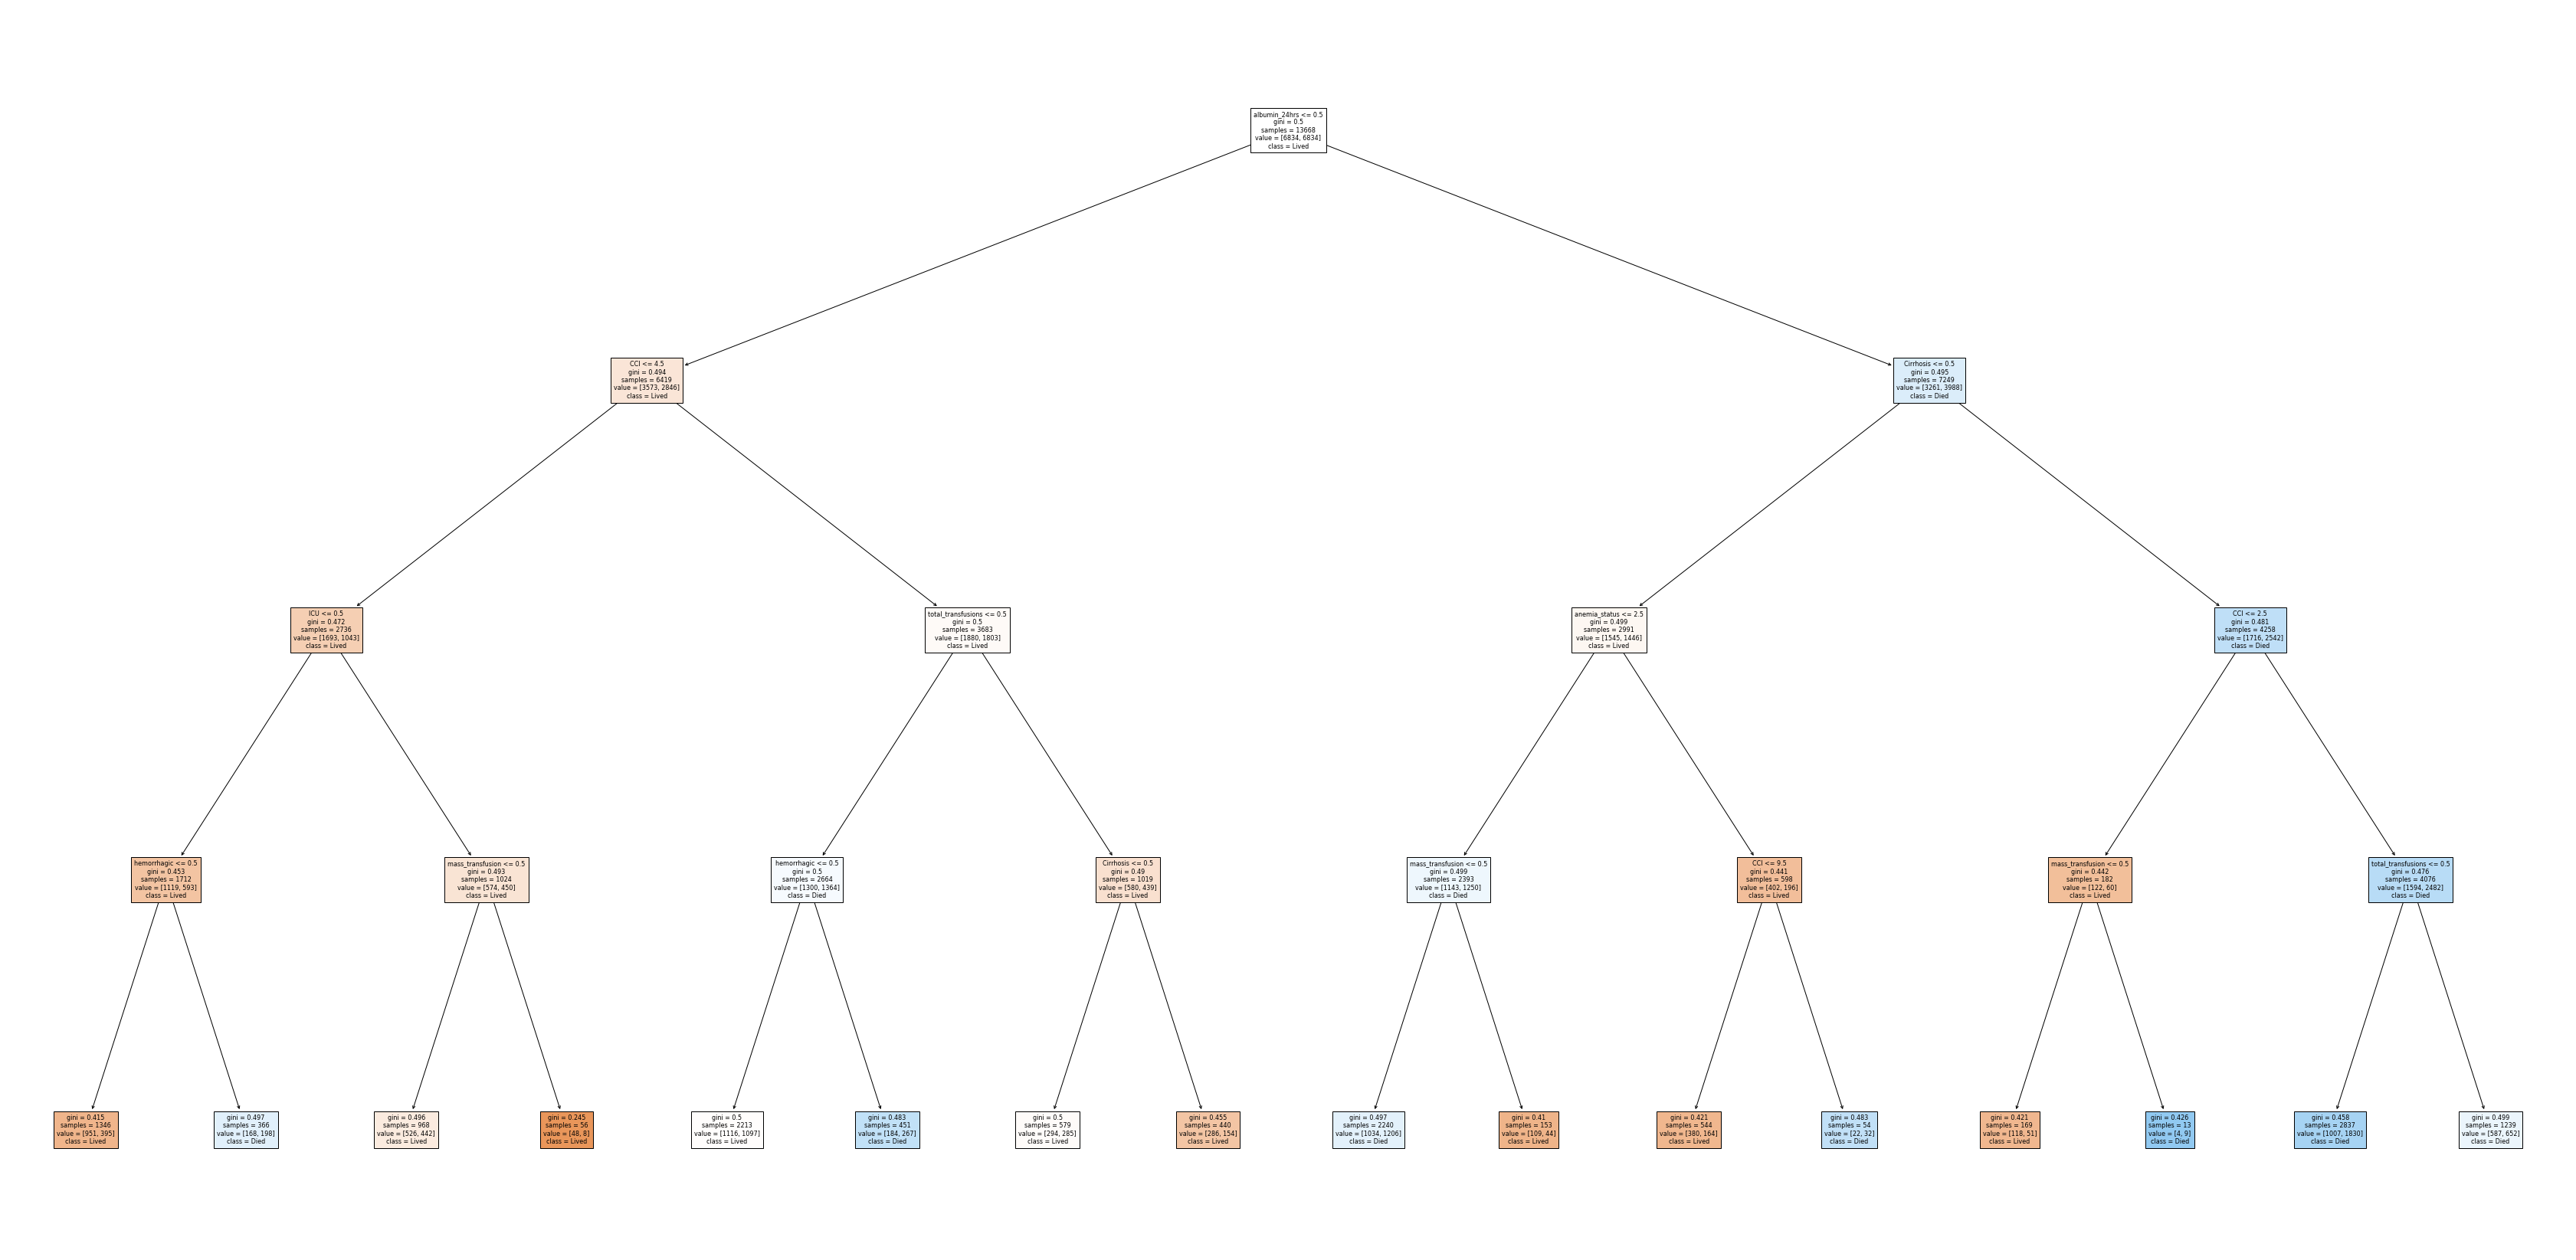

In [194]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [195]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D4_NCBL_MATCHED.png')

True

## 3: Decision Tree 

In [196]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

Feature: ICU Score: 0.13735
Feature: mass_transfusion Score: 0.03941
Feature: total_transfusions Score: 0.11500
Feature: anemia_status Score: 0.10785
Feature: CCI Score: 0.16236
Feature: Cirrhosis Score: 0.12856
Feature: hemorrhagic Score: 0.13971
Feature: albumin_24hrs Score: 0.16977


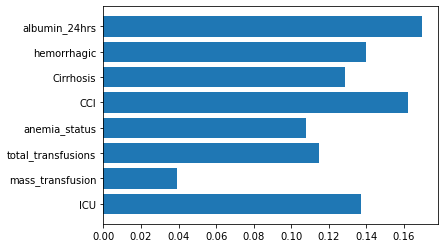

In [197]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [198]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [199]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3719 3115]
 [2290 4544]]


In [200]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.62      0.54      0.58      6834
           1       0.59      0.66      0.63      6834

    accuracy                           0.60     13668
   macro avg       0.61      0.60      0.60     13668
weighted avg       0.61      0.60      0.60     13668



In [201]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[908 813]
 [136 221]]


In [202]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.53      0.66      1721
           1       0.21      0.62      0.32       357

    accuracy                           0.54      2078
   macro avg       0.54      0.57      0.49      2078
weighted avg       0.76      0.54      0.60      2078



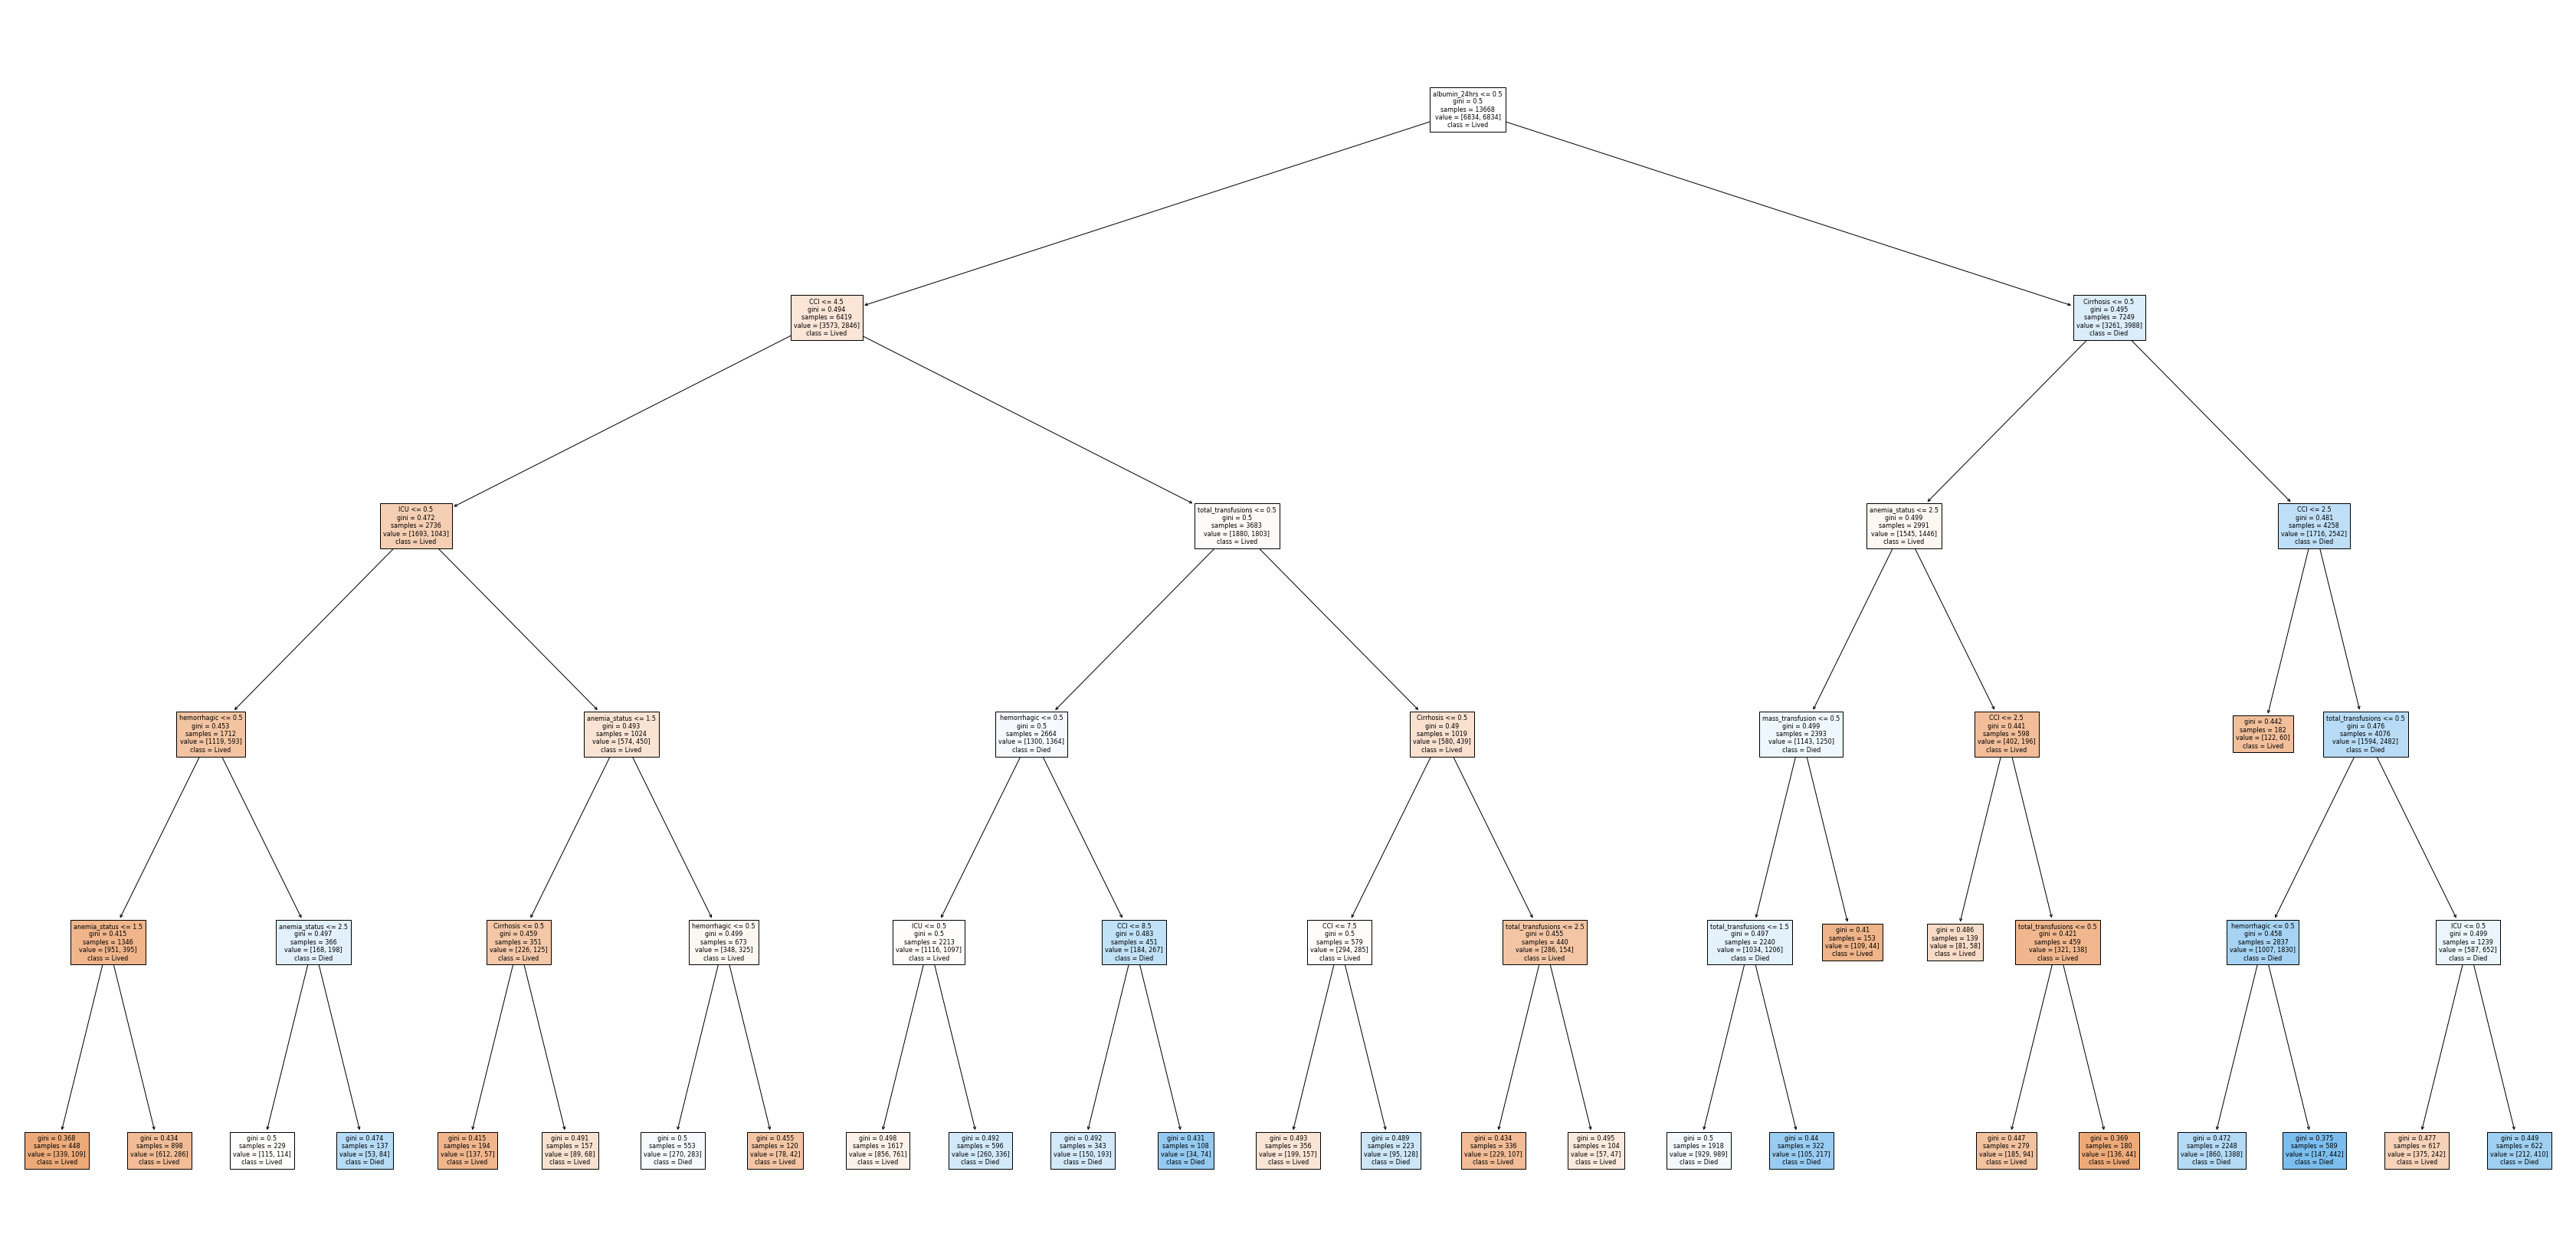

In [203]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [204]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D5_NCBL_MATCHED.png')

True

## 4: Decision Tree 

In [205]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.14829
Feature: mass_transfusion Score: 0.03323
Feature: total_transfusions Score: 0.16509
Feature: anemia_status Score: 0.12680
Feature: CCI Score: 0.14840
Feature: Cirrhosis Score: 0.11725
Feature: hemorrhagic Score: 0.11780
Feature: albumin_24hrs Score: 0.14314


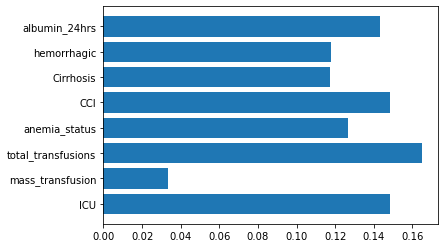

In [206]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [207]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [208]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4312 2522]
 [2725 4109]]


In [209]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      6834
           1       0.62      0.60      0.61      6834

    accuracy                           0.62     13668
   macro avg       0.62      0.62      0.62     13668
weighted avg       0.62      0.62      0.62     13668



In [210]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1060  661]
 [ 163  194]]


In [211]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      1721
           1       0.23      0.54      0.32       357

    accuracy                           0.60      2078
   macro avg       0.55      0.58      0.52      2078
weighted avg       0.76      0.60      0.65      2078



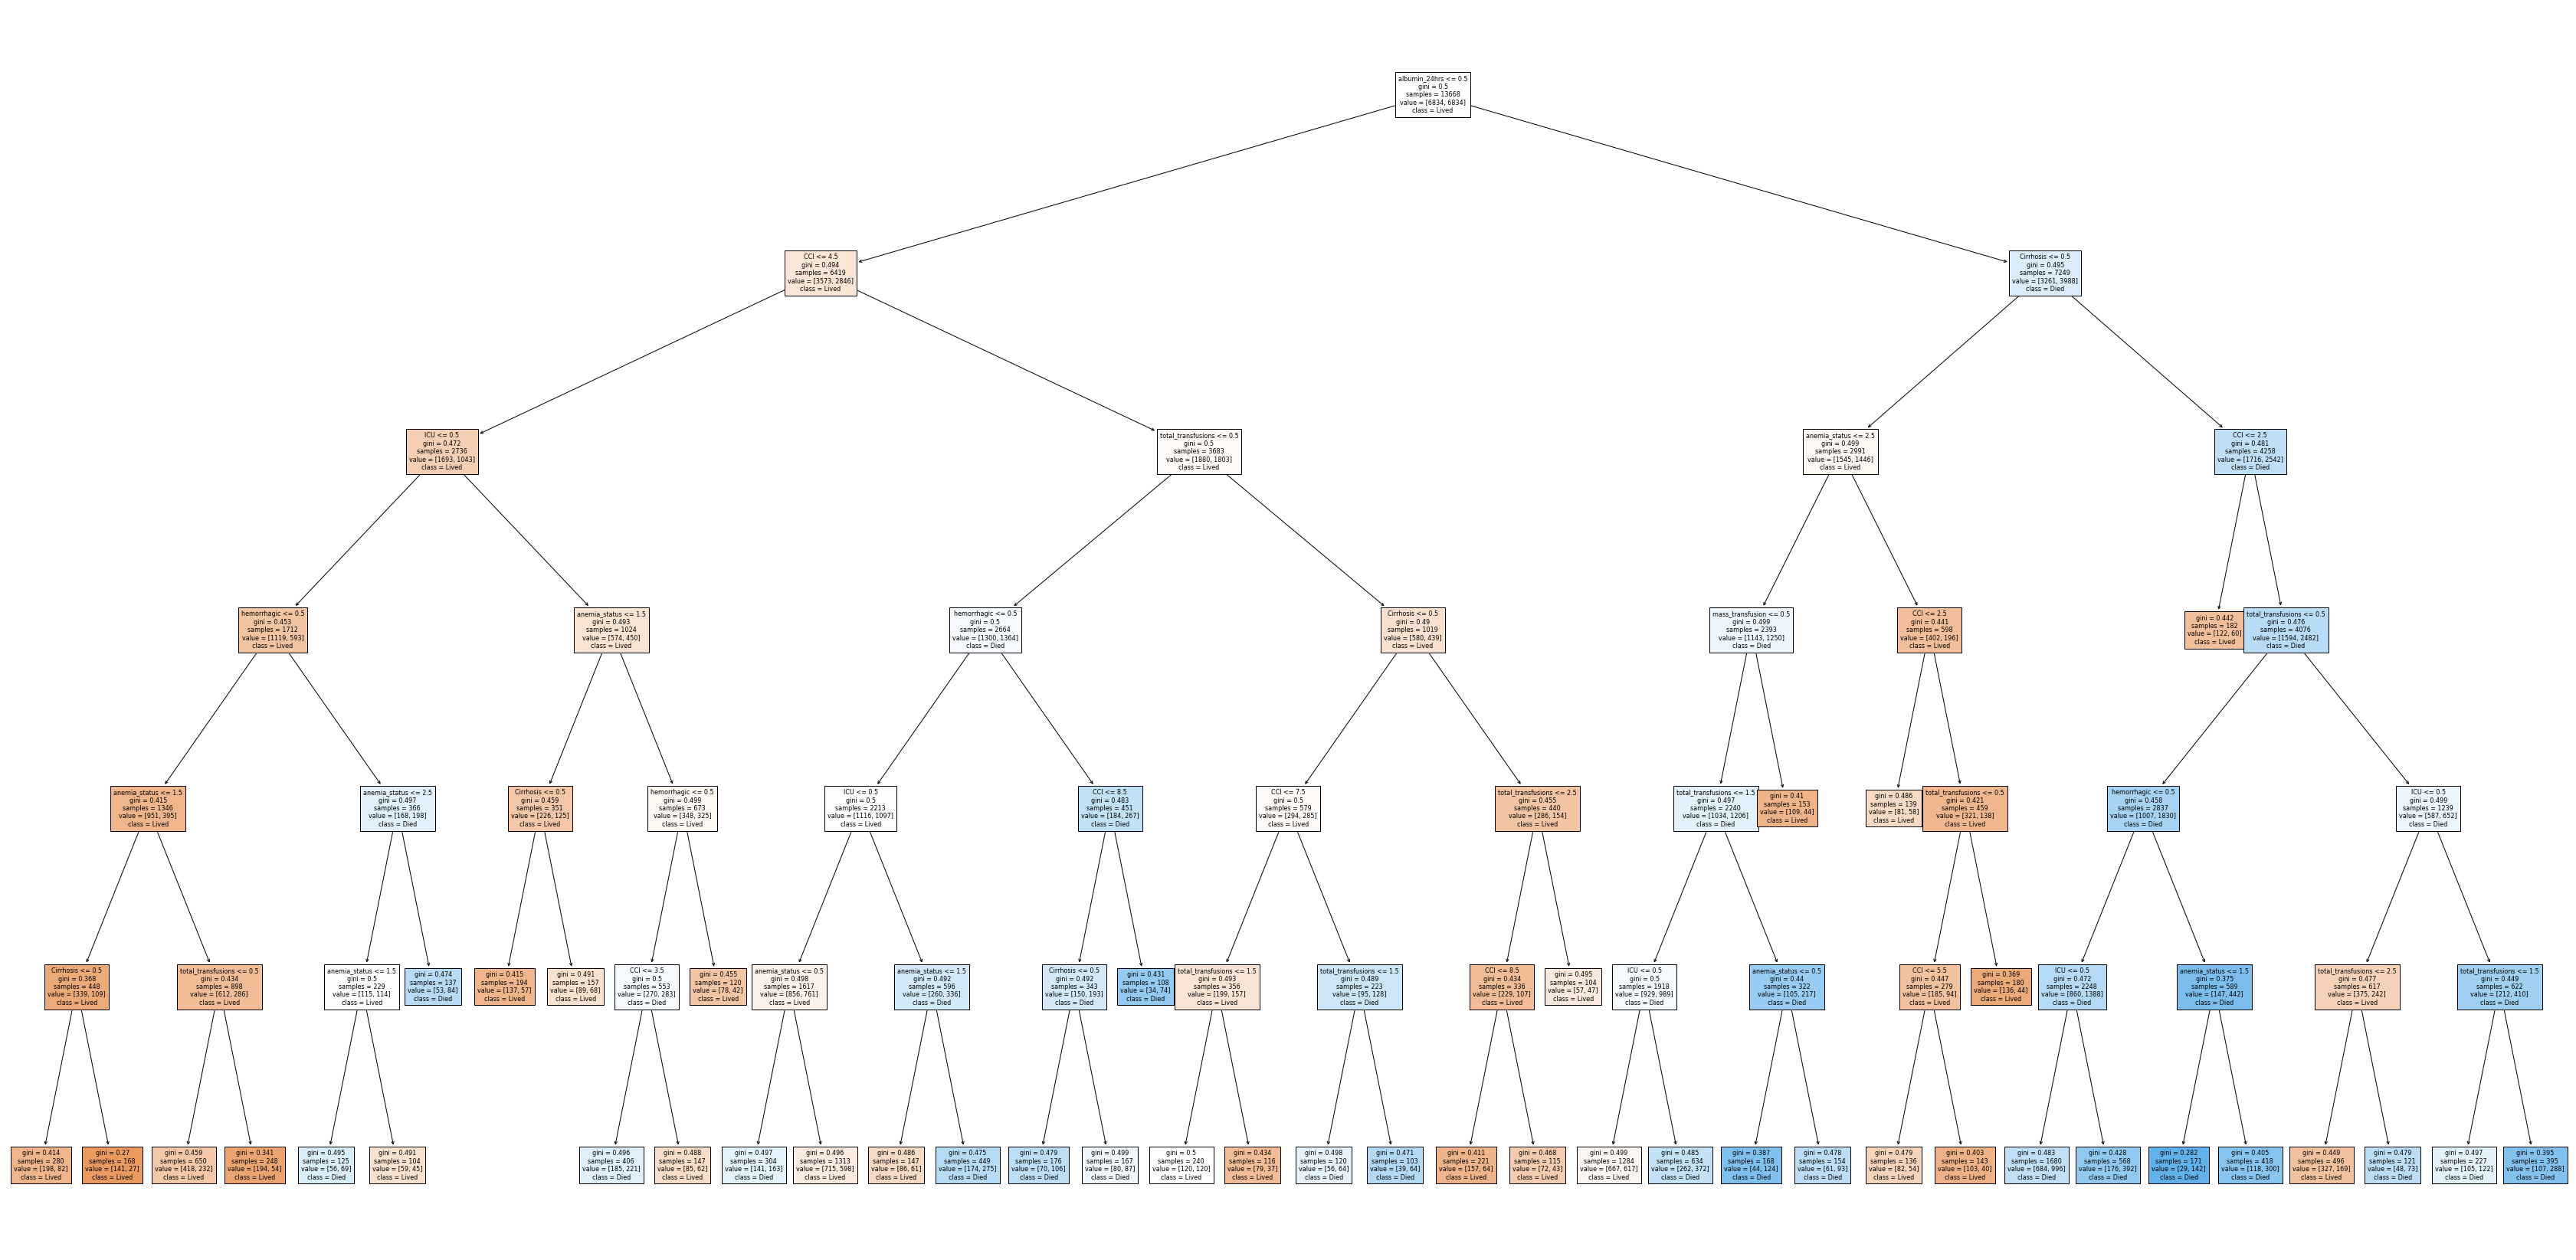

In [212]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [213]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D6_NCBL_MATCHED.png')

True

## 5: Decision Tree 

In [214]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.12976
Feature: mass_transfusion Score: 0.02908
Feature: total_transfusions Score: 0.15476
Feature: anemia_status Score: 0.15244
Feature: CCI Score: 0.19903
Feature: Cirrhosis Score: 0.10659
Feature: hemorrhagic Score: 0.10308
Feature: albumin_24hrs Score: 0.12526


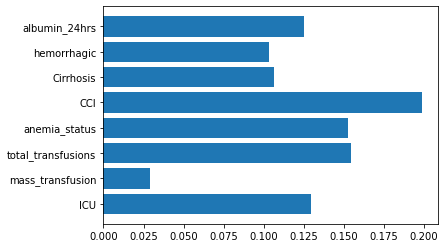

In [215]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [216]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [217]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[3623 3211]
 [1968 4866]]


In [218]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.65      0.53      0.58      6834
           1       0.60      0.71      0.65      6834

    accuracy                           0.62     13668
   macro avg       0.63      0.62      0.62     13668
weighted avg       0.63      0.62      0.62     13668



In [219]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[870 851]
 [130 227]]


In [220]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.51      0.64      1721
           1       0.21      0.64      0.32       357

    accuracy                           0.53      2078
   macro avg       0.54      0.57      0.48      2078
weighted avg       0.76      0.53      0.58      2078



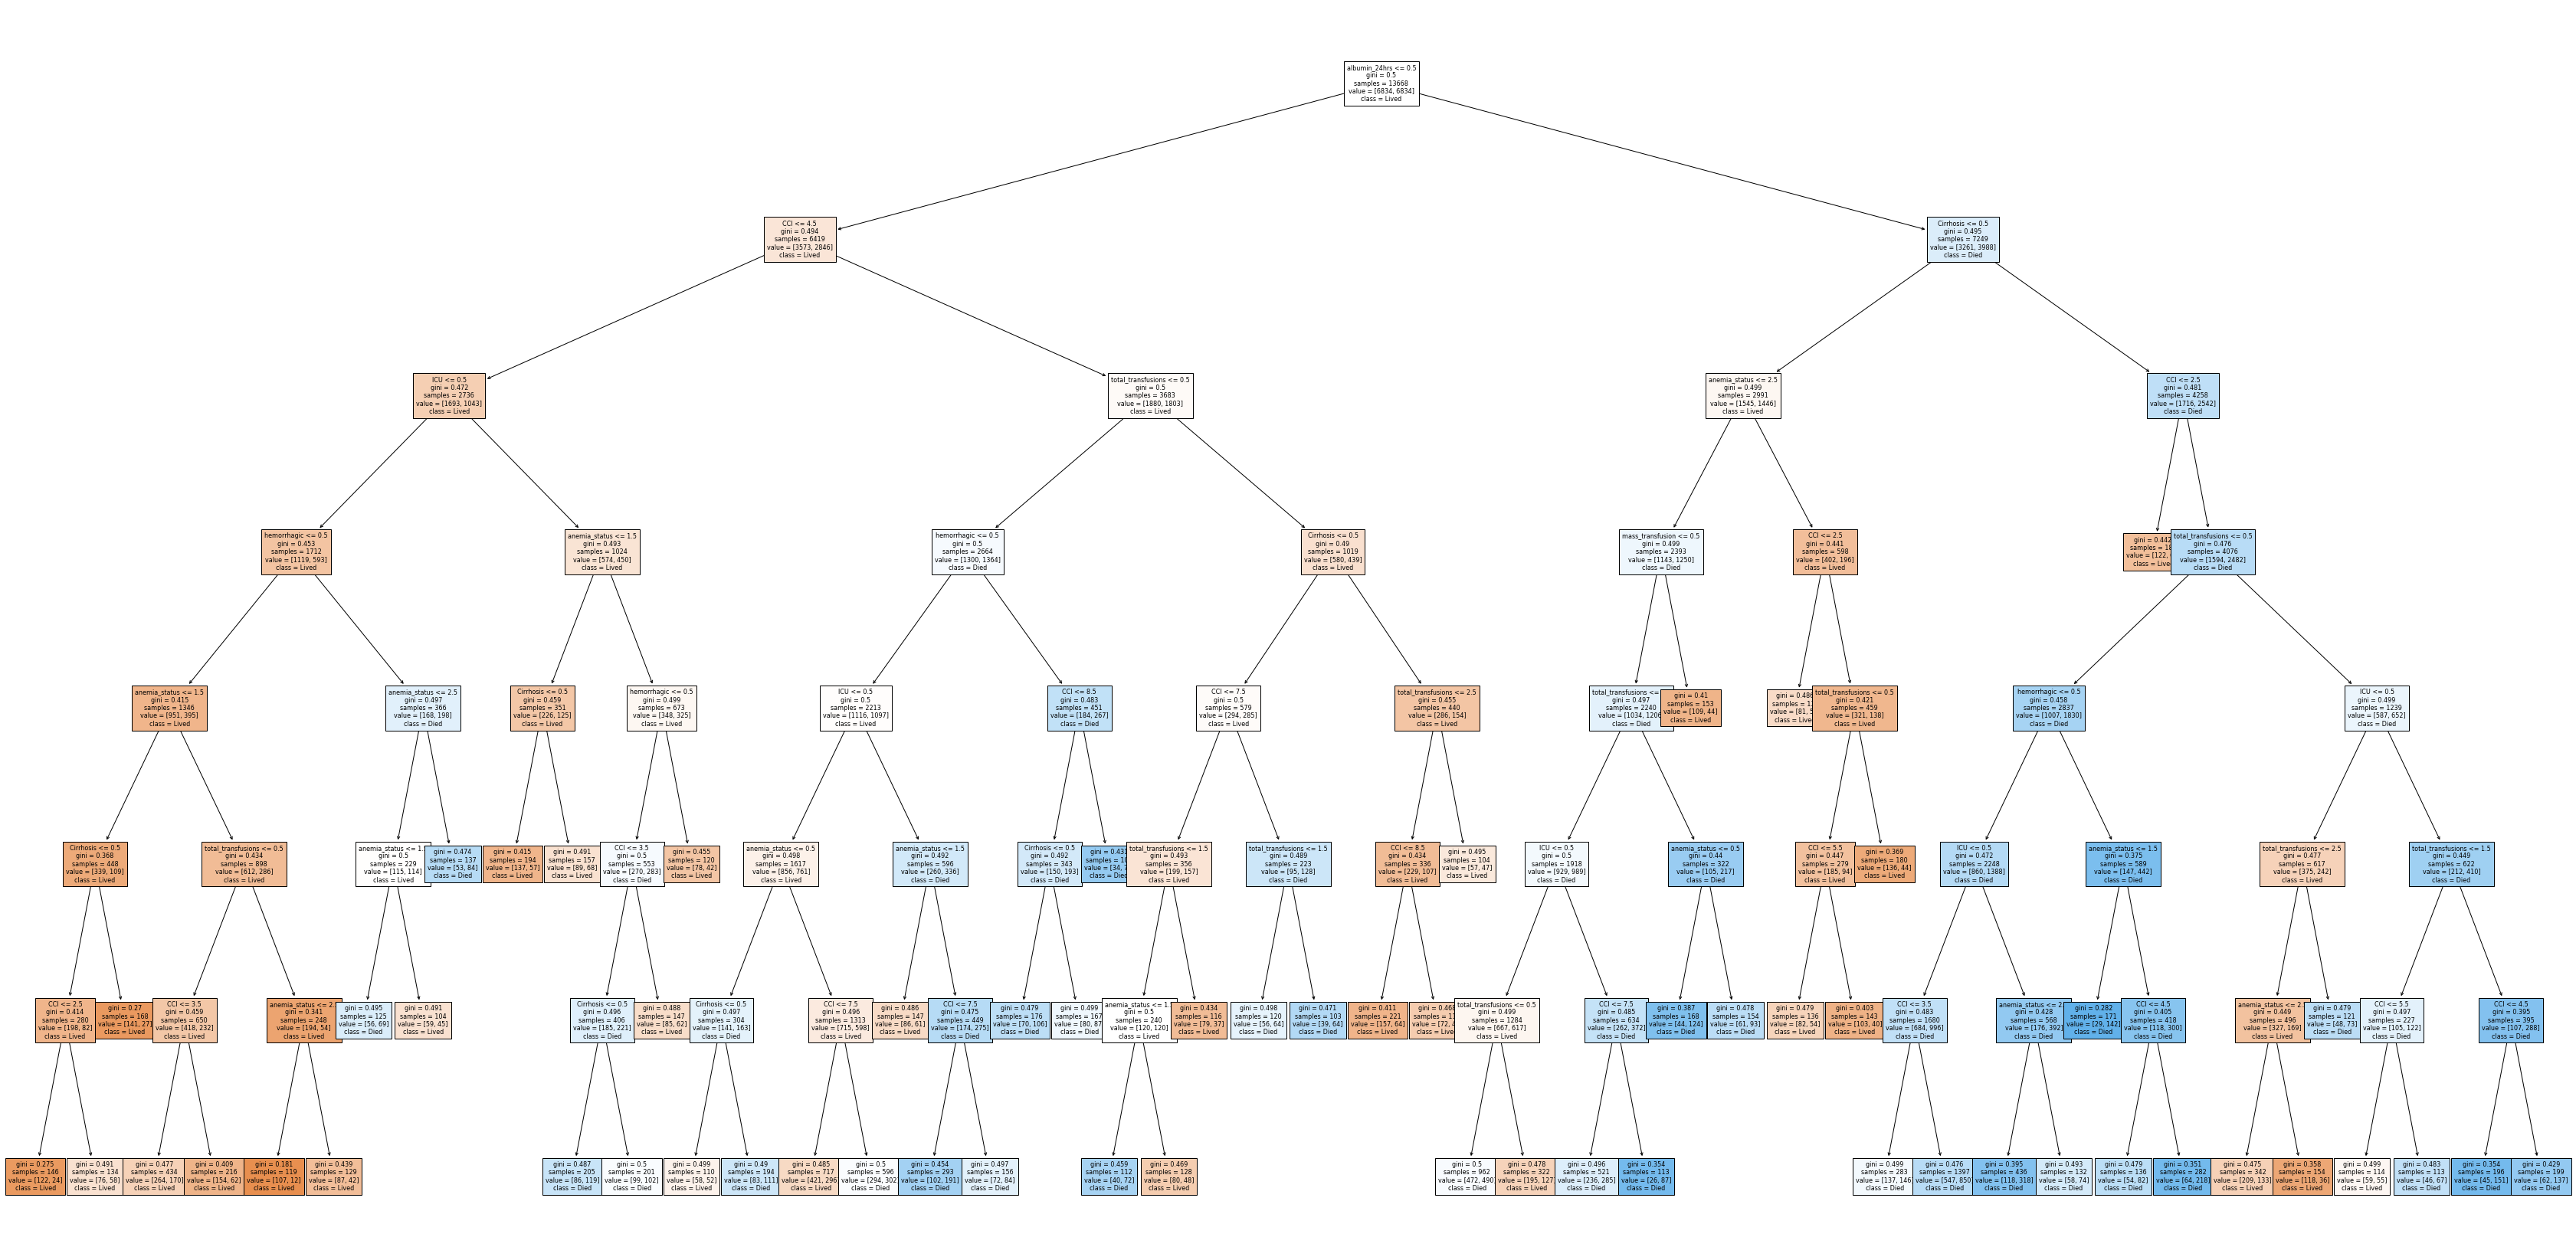

In [221]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [222]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('30DM_DT_D7_NCBL_MATCHED.png')

True

## Random Forest

In [223]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [224]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [225]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4497 2337]
 [2907 3927]]


In [226]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      6834
           1       0.63      0.57      0.60      6834

    accuracy                           0.62     13668
   macro avg       0.62      0.62      0.62     13668
weighted avg       0.62      0.62      0.62     13668



In [227]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1096  625]
 [ 160  197]]


In [228]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      1721
           1       0.24      0.55      0.33       357

    accuracy                           0.62      2078
   macro avg       0.56      0.59      0.54      2078
weighted avg       0.76      0.62      0.67      2078



Feature: ICU Score: 0.13846
Feature: mass_transfusion Score: 0.00615
Feature: total_transfusions Score: 0.15328
Feature: anemia_status Score: 0.10212
Feature: CCI Score: 0.19898
Feature: Cirrhosis Score: 0.09376
Feature: hemorrhagic Score: 0.08319
Feature: albumin_24hrs Score: 0.22406


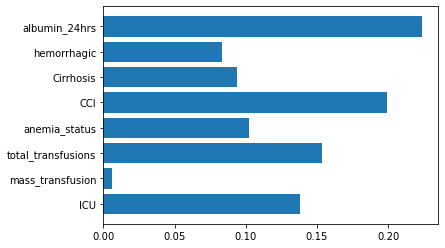

In [229]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()